<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/recommender-systems/03_matrix_factorization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/tutorials/blob/master/recommender-systems/03_matrix_factorization.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Matrix Factorization


## 1. Setup

In [0]:
!pip install --quiet cornac==1.5.2 adjustText

In [2]:
import os
import sys
import itertools

import scipy.sparse as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import MF, NMF, BaselineOnly

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

SEED = 42
VERBOSE = False

System version: 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
Cornac version: 1.5.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Low-Rank Approximation with Latent Factor Models

### Sample Data


In [3]:
sample_df = pd.read_csv(
  cache("https://static.preferred.ai/tutorials/recommender-systems/sample_data.csv"), 
  sep=",", names=["UserID", "ItemID", "Rating"]
)
dataset = cornac.data.Dataset.from_uir(sample_df.itertuples(index=False))
R = dataset.matrix.A
R_mask = (R > 0).astype(float)
pd.DataFrame(
  data=R,
  index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
  columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)]
).replace(0, np.nan)

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,7.0,6.0,7.0,4.0,5.0,4.0
User 2,6.0,7.0,NaN,4.0,3.0,4.0
User 3,NaN,3.0,3.0,1.0,1.0,NaN
User 4,1.0,2.0,2.0,3.0,3.0,4.0
User 5,1.0,NaN,1.0,2.0,3.0,3.0


### Singular Value Decomposition (SVD)

For any real rating matrix $ R \in \mathbb{R}^{N \times M} $, SVD seeks the following decomposition:

$$ R = U \Sigma V^T $$

where $ U \in \mathbb{R}^{N \times N} $ has orthonormal columns, $ \Sigma \in \mathbb{R}^{N \times M} $ is a matrix containing $D = \mathrm{min}(N,M)$ singular values $ \sigma_i \geq 0 $ on the main diagonal, and $ V \in \mathbb{R}^{M \times M} $ has orthonormal columns and rows.

Let's try to decompose the sample matrix with SVD and reconstruct it with only first singular value.

In [24]:
U, s, Vt = np.linalg.svd(R, full_matrices=True)
print("Singular values: ", s.round(3))
Sigma = np.zeros((R.shape[0], R.shape[1]))
Sigma[:R.shape[0], :R.shape[0]] = np.diag(s)

N = 1
Sigma = Sigma[:, :N]
Vt = Vt[:N, :]
recon_R = U.dot(Sigma.dot(Vt))

rmse = np.sqrt((((R - recon_R) ** 2) * R_mask).mean())
print(f"\nRMSE = {rmse:.3f}")
print("Reconstructed matrix:")
pd.DataFrame(recon_R.round(2),
             index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
             columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)])

Singular values:  [18.703  5.187  4.537  2.526  0.561]

RMSE = 1.065
Reconstructed matrix:


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,6.44,6.78,4.63,4.79,5.06,5.04
User 2,4.95,5.21,3.56,3.69,3.89,3.87
User 3,1.55,1.63,1.12,1.16,1.22,1.21
User 4,2.78,2.93,2.00,2.07,2.18,2.18
User 5,1.79,1.89,1.29,1.34,1.41,1.40


### Matrix Factorization (MF)

In matrix factorization, a sparse rating matrix $R \in \mathbb{R}^{N \times M}$, for $N$ users and $M$ items, is factorized into matrix $U \in \mathbb{R}^{N \times K}$ and matrix $V \in \mathbb{R}^{M \times K}$, as follows:

$$ R = UV^T $$

Each row of $U$ (or $V$) is referred to as latent *factors* of user (or item).  MF model in Cornac is implemented to use *stochastic gradient descent* for optimization.


Let's try to factorize the sample matrix using MF with $K=1$.

In [5]:
mf = MF(
  k=1, max_iter=100, learning_rate=0.01, lambda_reg=0.0, use_bias=False, verbose=VERBOSE
).fit(dataset)
print("User factors:\n", mf.u_factors)
print("Item factors:\n", mf.i_factors)

recon_R = np.empty(dataset.matrix.shape)
for u, i in itertools.product(range(recon_R.shape[0]), range(recon_R.shape[1])):
  recon_R[u, i] = mf.score(u, i)

rmse = np.sqrt((((R - recon_R) ** 2) * R_mask).mean())
print(f"\nRMSE = {rmse:.3f}")
print("Reconstructed matrix:")
pd.DataFrame(recon_R.round(2),
             index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
             columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)])

User factors:
 [[-2.9987273]
 [-2.75317  ]
 [-1.1650457]
 [-1.2857331]
 [-1.0619403]]
Item factors:
 [[-2.0800748]
 [-2.2308729]
 [-2.1739051]
 [-1.447282 ]
 [-1.4934179]
 [-1.5902187]]

RMSE = 0.884
Reconstructed matrix:


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,6.24,6.69,6.52,4.34,4.48,4.77
User 2,5.73,6.14,5.99,3.98,4.11,4.38
User 3,2.42,2.60,2.53,1.69,1.74,1.85
User 4,2.67,2.87,2.80,1.86,1.92,2.04
User 5,2.21,2.37,2.31,1.54,1.59,1.69


### Let's Try MF on a Real Dataset

Here, we try MF on MovieLens 100K dataset with different number of factors.

In [6]:
K = 100
mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.0, use_bias=False,
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")
  
data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[mf], metrics=[rmse]).run()


TEST:
...
          |   RMSE | Train (s) | Test (s)
--------- + ------ + --------- + --------
MF(K=100) | 0.8957 |    0.4615 |   0.4326



## 3. Regularization

In real settings, rating matrix is normally very sparse, this can easily cause overfitting.  A common approach for addressing this problem is to use *regularization*.  In MF, we minimize *l2-norm* of the user and item factors, the regularization term is defined as:

$$ \mathrm{l2\_reg} = \frac{\lambda}{2} \big( ||U||^2 + ||V||^2 \big) $$

Let's see how MF with regularization perform.

In [7]:
K = 100
lbd = 0.01
mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=lbd, use_bias=False,
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K},lambda={lbd:.4f})")

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[mf], metrics=[rmse]).run()


TEST:
...
                        |   RMSE | Train (s) | Test (s)
----------------------- + ------ + --------- + --------
MF(K=100,lambda=0.0100) | 0.8943 |    0.4694 |   0.4163



## 4. Effect of Bias

Incorporating bias terms into prediction formular:

$$\hat{r}_{ij} = \mu + b_u + b_i + \mathbf{u}_i^T \mathbf{v}_j $$

where $\mu$ is global average rating, $b_u$ and $b_i$ are user bias and item bias, respectively.

Let's compare MF models with and without biases.  The *BaselineOnly* model is the one using only bias terms for prediction ($\hat{r}_{ij} = \mu + b_u + b_i $).

In [8]:
K = 100
models = [
  BaselineOnly(max_iter=20, learning_rate=0.01, lambda_reg=0.01, verbose=VERBOSE),
  MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, use_bias=False, 
     verbose=VERBOSE, seed=SEED, name=f"MF(K={K})"),
  MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, use_bias=True, 
     verbose=VERBOSE, seed=SEED, name=f"MF(K={K},bias)"),
]

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=models, metrics=[rmse]).run()


TEST:
...
               |   RMSE | Train (s) | Test (s)
-------------- + ------ + --------- + --------
BaselineOnly   | 0.9105 |    0.0084 |   0.3247
MF(K=100)      | 0.8943 |    0.4739 |   0.4101
MF(K=100,bias) | 0.8878 |    0.4664 |   0.3682



## 5. Non-Negative Matrix Factorization (NMF)

The laten factors are constrained to be non-negative.

In [9]:
nmf = NMF(
  k=1, max_iter=100, learning_rate=0.01, lambda_reg=0.0, verbose=VERBOSE
).fit(dataset)
print("User factors:\n", nmf.u_factors)
print("Item factors:\n", nmf.i_factors)

recon_R = np.empty(dataset.matrix.shape)
for u, i in itertools.product(range(recon_R.shape[0]), range(recon_R.shape[1])):
  recon_R[u, i] = nmf.score(u, i)

rmse = np.sqrt((((R - recon_R) ** 2) * R_mask).mean())
print(f"\nRMSE = {rmse:.3f}")
print("Reconstructed matrix:")
pd.DataFrame(recon_R.round(2),
             index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
             columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)])

User factors:
 [[2.728834 ]
 [2.4983075]
 [1.0454211]
 [1.1400911]
 [0.9413226]]
Item factors:
 [[2.111305 ]
 [2.2633426]
 [2.1856062]
 [1.4850909]
 [1.5489188]
 [1.6513072]]

RMSE = 0.922
Reconstructed matrix:


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,5.76,6.18,5.96,4.05,4.23,4.51
User 2,5.27,5.65,5.46,3.71,3.87,4.13
User 3,2.21,2.37,2.28,1.55,1.62,1.73
User 4,2.41,2.58,2.49,1.69,1.77,1.88
User 5,1.99,2.13,2.06,1.40,1.46,1.55


### NMF on MovieLens 100K

In [10]:
K = 10
nmf = NMF(k=K, max_iter=200, learning_rate=0.01, lambda_reg=0.01, use_bias=False,
          verbose=VERBOSE, seed=SEED, name=f"NMF(K={K})")
          
data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[nmf], metrics=[rmse]).run()


TEST:
...
          |   RMSE | Train (s) | Test (s)
--------- + ------ + --------- + --------
NMF(K=10) | 1.0196 |    0.8251 |   0.4102



## 6. Interpreting Latent Factors

In [11]:
# Download some information of MovieLens 100K dataset
item_df = pd.read_csv(
  cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.item"), 
  sep="|", encoding="ISO-8859-1",
  names=["ItemID", "Title", "Release Date", "Video Release Date", "IMDb URL", 
         "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", 
         "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", 
         "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
).set_index("ItemID").drop(columns=["Video Release Date", "IMDb URL", "unknown"])
item_df.head()

,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


Let's retrain two models MF and NMF with 10 latent factors.

In [12]:
K = 10
mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, use_bias=False, 
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")
nmf = NMF(k=K, max_iter=200, learning_rate=0.01, lambda_reg=0.01, use_bias=False, 
          verbose=VERBOSE, seed=SEED, name=f"NMF(K={K})")
  
data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[mf, nmf], metrics=[rmse]).run()


TEST:
...
          |   RMSE | Train (s) | Test (s)
--------- + ------ + --------- + --------
MF(K=10)  | 0.9027 |    0.0816 |   0.4111
NMF(K=10) | 1.0196 |    0.8502 |   0.4127



### MF

Below is the variance of each latent dimension.

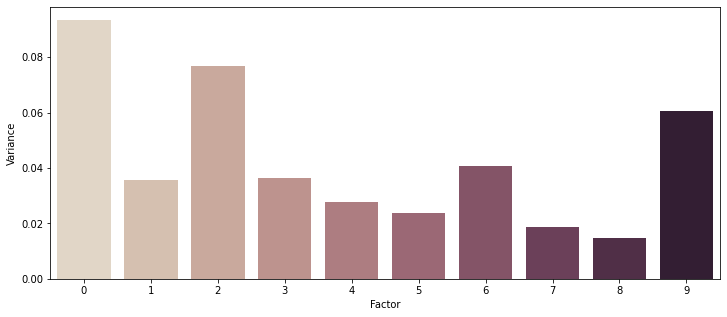

In [13]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(mf.i_factors, axis=0)})
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);

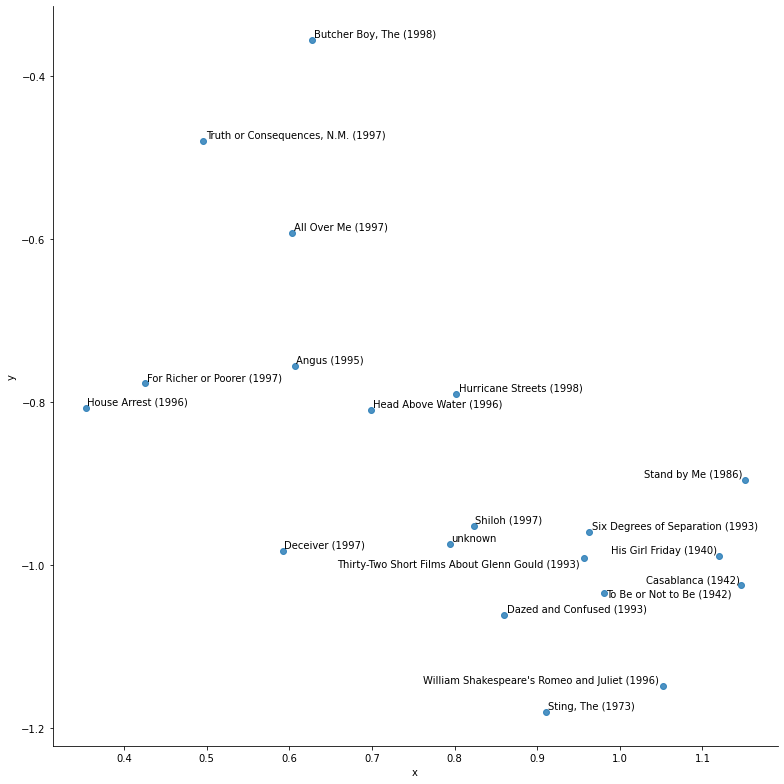

In [14]:
TOP2F = (0, 2)
SAMPLE_SIZE = 20

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(mf.i_factors.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=mf.i_factors[sample_inds][:, TOP2F], columns=["x", "y"])

sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
item_idx2id = list(mf.train_set.item_ids)
titles = item_df.loc[[int(item_idx2id[i]) for i in sample_inds]]["Title"].values
adjust_text(
  [plt.text(*sample_df.loc[i].values, titles[i], size=10) for i in range(len(titles))]
);

### NMF

Below is the variance of each latent dimension.

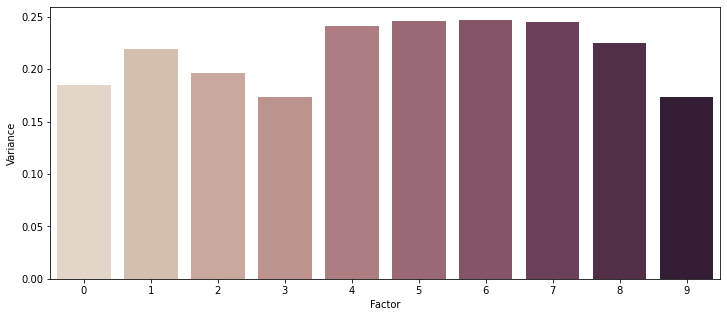

In [15]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(nmf.i_factors, axis=0)})
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);

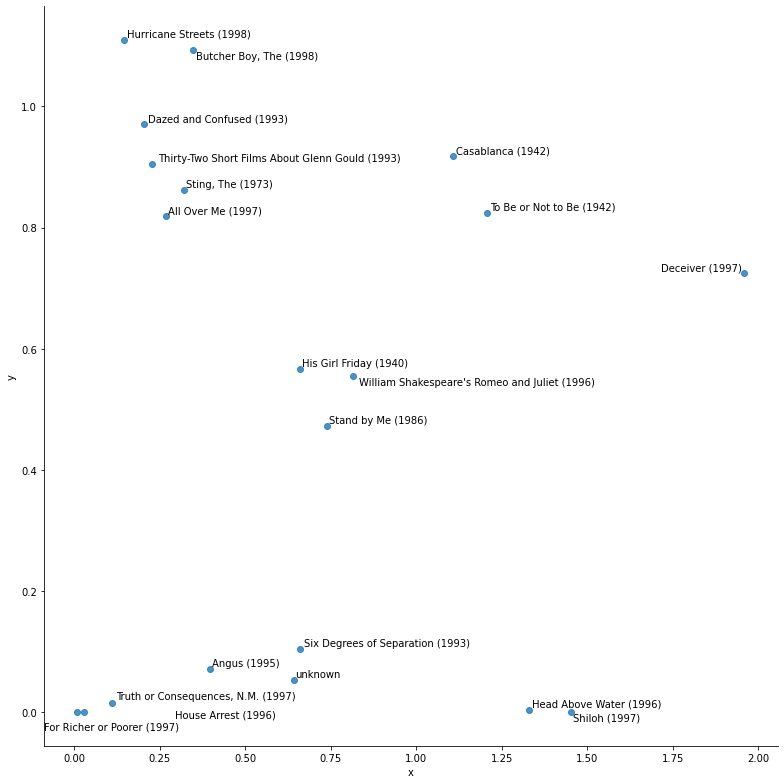

In [16]:
TOP2F = (5, 6)
SAMPLE_SIZE = 20

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(nmf.i_factors.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=nmf.i_factors[sample_inds][:, TOP2F], columns=["x", "y"])

sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
item_idx2id = list(nmf.train_set.item_ids)
titles = item_df.loc[[int(item_idx2id[i]) for i in sample_inds]]["Title"].values
adjust_text(
  [plt.text(*sample_df.loc[i].values, titles[i], size=10) for i in range(len(titles))]
);

Let's see what are the top movies (i.e., highest values) of each latent dimension.

In [17]:
item_idx2id = list(nmf.train_set.item_ids)
top_items = {}
for k in range(K):
  top_inds = np.argsort(nmf.i_factors[:, k])[-5:][::-1]
  top_items[f"Factor {k}"] = item_df.loc[[int(item_idx2id[i]) for i in top_inds]]["Title"].values
pd.DataFrame(top_items)

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
0,Carpool (1996),Best Men (1997),Bhaji on the Beach (1993),"Garden of Finzi-Contini, The (Giardino dei Fin...",Tough and Deadly (1995),"Boys, Les (1997)",Ruby in Paradise (1993),Deep Rising (1998),City of Industry (1997),Gumby: The Movie (1995)
1,"Good Man in Africa, A (1994)",Paradise Lost: The Child Murders at Robin Hood...,Panther (1995),Kissed (1996),8 Heads in a Duffel Bag (1997),Nénette et Boni (1996),Mina Tannenbaum (1994),Captives (1994),Romper Stomper (1992),Turbulence (1997)
2,"Neon Bible, The (1995)",Angel Baby (1995),Nina Takes a Lover (1994),"Ice Storm, The (1997)",Selena (1997),Ghost in the Shell (Kokaku kidotai) (1995),Harlem (1993),"Baby-Sitters Club, The (1995)",Tetsuo II: Body Hammer (1992),"Man in the Iron Mask, The (1998)"
3,C'est arrivé près de chez vous (1992),Cemetery Man (Dellamorte Dellamore) (1994),Cats Don't Dance (1997),"Low Down Dirty Shame, A (1994)",Love Jones (1997),Grace of My Heart (1996),"Secret Agent, The (1996)",Prisoner of the Mountains (Kavkazsky Plennik) ...,"Boys, Les (1997)",Radioland Murders (1994)
4,Miami Rhapsody (1995),Underground (1995),Until the End of the World (Bis ans Ende der W...,Dunston Checks In (1996),"Little Princess, The (1939)",Stalingrad (1993),"White Balloon, The (1995)",Guilty as Sin (1993),To Live (Huozhe) (1994),Infinity (1996)


For each latent factor, we take the top 100 movies then count per genres.  This somehow shows relationships between latent factors and movie genres.

In [18]:
item_idx2id = list(nmf.train_set.item_ids)
top_genres = {}
for k in range(K):
  top_inds = np.argsort(nmf.i_factors[:, k])[-100:]
  top_items = item_df.loc[[int(item_idx2id[i]) for i in top_inds]]
  top_genres[f"Factor {k}"] = top_items.drop(columns=["Title", "Release Date"]).sum(axis=0)
pd.DataFrame(top_genres)

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
Action,18,11,12,17,12,7,4,5,20,15
Adventure,12,4,11,3,5,3,6,2,13,11
Animation,0,1,1,5,3,2,5,0,0,3
Children's,5,3,6,5,5,5,2,2,8,20
Comedy,27,29,31,36,22,32,33,28,24,38
Crime,7,9,5,9,4,3,6,4,9,3
Documentary,3,10,1,3,1,6,4,3,2,3
Drama,39,42,45,43,49,50,55,60,45,30
Fantasy,0,1,1,0,1,1,0,0,1,2
Film-Noir,1,0,0,3,2,1,0,1,0,1


## References

1.   Aggarwal, C. C. (2016). Recommender systems (Vol. 1). Cham: Springer International Publishing.
2.   Koren, Y., Bell, R., & Volinsky, C. (2009). Matrix factorization techniques for recommender systems. Computer, 42(8), 30-37.
3.   Lee, D. D., & Seung, H. S. (2001). Algorithms for non-negative matrix factorization. In Advances in neural information processing systems (pp. 556-562).

